## Machine Learning Exercise 2 - Introduction to Logistic Regression for Predictive Analytics

For this exercise, you'll be using the same wego dataset from last exercise. Your goal will be to predict whether a trip is on-time.

1. Create a new (target) variable, ON-TIME. We'll consider a trip to be on-time if it is no more than 6 minutes late (ADHERENCE >= -6) and is  no more than 1 minute early (ADHERENCE <= 1).

**Note:** Make sure that you perform a train/test split before fitting any models so that you can properly measure the performance of the model.

2. Fit a logistic regression model predicting the ADHERENCE using the ROUTE_ABBR and ROUTE_DIRECTION_NAME columns. How accurate is this model? How does it do in terms of precision and recall? What about ROC-AUC and calibration?

3. Now, try using the ROUTE_ABBR, ROUTE_DIRECTION_NAME, and OPERATOR. Does this improve the model? Note: you may need to increase the max_iter parameter of your model in order for it to converge.

4. Finally, the data you have been provided has an STARTING_ADHERENCE column, which contains the ADHERENCE at the beginning of the route. If you add this metric, does it improve the model?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score

In [2]:
wego = pd.read_csv('../data/wego_ml.csv')
wego

,ID,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,...,ADJUSTED_ONTIME_COUNT,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,NextDay_Scheduled,NextDay_Actual_Arrival,NextDay_Actual_Departure,STARTING_ADHERENCE
0,120230801_345104,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,...,1,0,0.0,0,19,0.000000,0,0,0,-2.133333
1,120230801_345105,120230801,1,99457895,2023-08-01,22,2200,1040,345105,0,...,1,0,0.0,0,51,0.000000,0,0,0,-1.583333
2,120230801_345106,120230801,1,99457899,2023-08-01,22,2200,1040,345106,0,...,1,0,0.0,0,80,0.000000,0,0,0,-1.716666
3,120230801_345107,120230801,1,99457902,2023-08-01,22,2200,1040,345107,0,...,0,0,0.0,0,112,0.000000,0,0,0,-1.316666
4,120230801_345108,120230801,1,99457906,2023-08-01,22,2200,1040,345108,0,...,1,0,0.0,0,141,0.000000,0,0,0,-1.516666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64328,120230913_353986,120230913,1,100702403,2023-09-13,50,8601,2400,353986,0,...,0,0,0.0,0,23,3.966666,0,0,0,-15.183333
64329,120230913_353988,120230913,1,100702412,2023-09-13,55,8604,359,353988,0,...,1,0,0.0,0,2,44.400000,0,0,0,-2.900000
64330,120230913_354069,120230913,1,100702754,2023-09-13,50,9302,2423,354069,0,...,1,0,0.0,0,2,35.916666,0,0,0,-0.300000
64331,120230913_354098,120230913,1,100702882,2023-09-13,50,9950,2563,354098,0,...,0,0,0.0,0,2,51.966666,0,0,0,1.933333


**1. Create a new (target) variable, ON-TIME. We'll consider a trip to be on-time if it is no more than 6 minutes late (ADHERENCE >= -6) and is  no more than 1 minute early (ADHERENCE <= 1).**

In [3]:
wego['ON-TIME'] = wego['ADHERENCE'].apply(lambda x: True if (-6 <= x <= 1) else False)

In [4]:
wego.head(10)

,ID,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,...,STOP_CANCELLED,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,NextDay_Scheduled,NextDay_Actual_Arrival,NextDay_Actual_Departure,STARTING_ADHERENCE,ON-TIME
0,120230801_345104,120230801,1,99457892,2023-08-01,22,2200,1040,345104,0,...,0,0.0,0,19,0.0,0,0,0,-2.133333,True
1,120230801_345105,120230801,1,99457895,2023-08-01,22,2200,1040,345105,0,...,0,0.0,0,51,0.0,0,0,0,-1.583333,True
2,120230801_345106,120230801,1,99457899,2023-08-01,22,2200,1040,345106,0,...,0,0.0,0,80,0.0,0,0,0,-1.716666,True
3,120230801_345107,120230801,1,99457902,2023-08-01,22,2200,1040,345107,0,...,0,0.0,0,112,0.0,0,0,0,-1.316666,False
4,120230801_345108,120230801,1,99457906,2023-08-01,22,2200,1040,345108,0,...,0,0.0,0,141,0.0,0,0,0,-1.516666,True
5,120230801_345109,120230801,1,99457910,2023-08-01,22,2200,1040,345109,0,...,0,0.0,0,180,0.0,0,0,0,-1.733333,True
6,120230801_345110,120230801,1,99457913,2023-08-01,22,2200,1040,345110,0,...,0,0.0,0,204,0.0,0,0,0,-1.250000,True
7,120230801_345111,120230801,1,99457916,2023-08-01,22,2200,1040,345111,0,...,0,0.0,0,236,0.0,0,0,0,-3.016666,True
8,120230801_345112,120230801,1,99457919,2023-08-01,22,2200,1040,345112,0,...,0,0.0,0,264,0.0,0,0,0,-2.600000,True
9,120230801_345113,120230801,1,99457922,2023-08-01,22,2200,1040,345113,0,...,0,0.0,0,296,0.0,0,0,0,-1.450000,False


**2. Fit a logistic regression model predicting the ADHERENCE using the ROUTE_ABBR and ROUTE_DIRECTION_NAME columns. How accurate is this model? How does it do in terms of precision and recall? What about ROC-AUC and calibration?**

In [5]:
predictors = ['ROUTE_ABBR', 'ROUTE_DIRECTION_NAME']
X = wego[predictors]
X = pd.get_dummies(X, columns=predictors)
y = wego['ON-TIME']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 321, stratify = y)
logreg = LogisticRegression().fit(X_train, y_train)

Extract out the coefficients:

In [6]:
logreg.intercept_

array([1.08030544])

In [7]:
logreg.coef_

array([[-0.22242432, -0.08524548,  0.70093713,  0.45120402,  0.28365654,
        -0.20537229, -0.77711272, -0.14624289, -0.29854733,  0.29794731]])

In [8]:
logreg.predict_proba(X_test)[:5]

array([[0.15950586, 0.84049414],
       [0.23633472, 0.76366528],
       [0.35408292, 0.64591708],
       [0.23942611, 0.76057389],
       [0.22566341, 0.77433659]])

In [9]:
logreg.predict(X_test)

array([ True,  True,  True, ...,  True,  True,  True])

In [10]:
X_test.assign(ontime_prob = logreg.predict_proba(X_test)[:,1],
             prediction = logreg.predict(X_test),
             true = y_test)

,ROUTE_ABBR_3,ROUTE_ABBR_7,ROUTE_ABBR_22,ROUTE_ABBR_23,ROUTE_ABBR_50,ROUTE_ABBR_52,ROUTE_ABBR_55,ROUTE_ABBR_56,ROUTE_DIRECTION_NAME_FROM DOWNTOWN,ROUTE_DIRECTION_NAME_TO DOWNTOWN,ontime_prob,prediction,true
21408,0,0,0,0,1,0,0,0,0,1,0.840494,True,False
17844,0,0,0,0,0,1,0,0,0,1,0.763665,True,True
22576,0,0,0,0,0,0,1,0,0,1,0.645917,True,False
15162,1,0,0,0,0,0,0,0,0,1,0.760574,True,True
35894,0,0,0,1,0,0,0,0,1,0,0.774337,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18453,0,0,0,0,1,0,0,0,1,0,0.743724,True,False
35787,0,0,1,0,0,0,0,0,0,1,0.888864,True,True
37245,0,0,0,0,0,1,0,0,0,1,0.763665,True,True
28637,0,0,0,1,0,0,0,0,1,0,0.774337,True,True


In [11]:
accuracy_score(y_test, logreg.predict(X_test))

0.7278662024372047

In [12]:
confusion_matrix(y_test, logreg.predict(X_test))

array([[    0,  4377],
       [    0, 11707]], dtype=int64)

In [13]:
print(classification_report(y_test, logreg.predict(X_test)))

              precision    recall  f1-score   support

       False       0.00      0.00      0.00      4377
        True       0.73      1.00      0.84     11707

    accuracy                           0.73     16084
   macro avg       0.36      0.50      0.42     16084
weighted avg       0.53      0.73      0.61     16084



C:\Users\MJ\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MJ\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\MJ\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


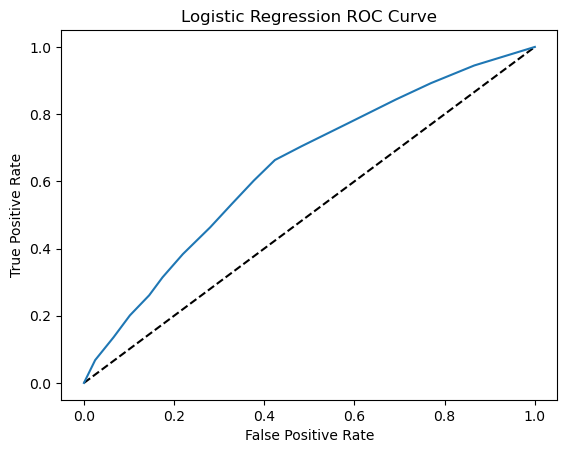

In [14]:
from sklearn.metrics import roc_curve
ontime_prob = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, ontime_prob, pos_label = True)
plt.plot([0, 1], [0, 1],
'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

In [15]:
print(roc_auc_score(y_test, ontime_prob))

0.6407340439169869


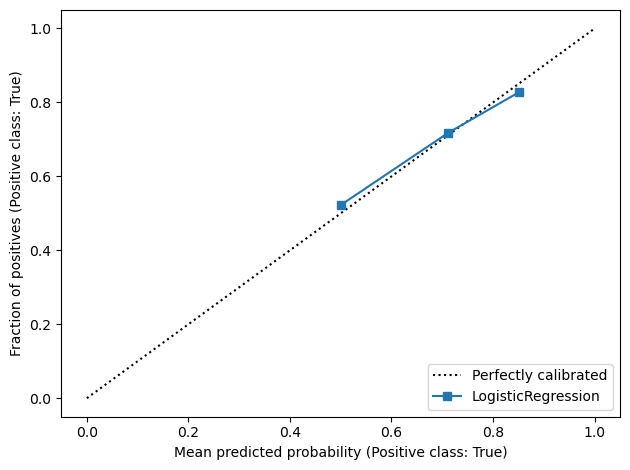

In [16]:
from sklearn.calibration import CalibrationDisplay
CalibrationDisplay.from_estimator(logreg, X_test, y_test)
plt.tight_layout()

**3. Now, try using the ROUTE_ABBR, ROUTE_DIRECTION_NAME, and OPERATOR. Does this improve the model? Note: you may need to increase the max_iter parameter of your model in order for it to converge.**

In [17]:
predictors = ['ROUTE_ABBR', 'ROUTE_DIRECTION_NAME', 'OPERATOR']
X = wego[predictors]
y = wego['ON-TIME']

## Setting a threshold with Operator counts
operators = wego['OPERATOR'].value_counts()[lambda x:x > 50].index.tolist()
X.loc[X['OPERATOR'].isin(operators), 'OPERATOR'] = -999999

X = pd.get_dummies(X, columns=predictors, drop_first = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 321, stratify = y)
logreg = LogisticRegression(max_iter=1000).fit(X_train, y_train)

Extract out the coefficients:

In [18]:
logreg.intercept_

array([0.56668614])

In [19]:
logreg.coef_

array([[ 1.44656960e-01,  9.29366534e-01,  6.66471379e-01,
         5.09656358e-01,  1.29154461e-02, -5.48504008e-01,
         7.39656458e-02,  5.92272567e-01, -7.10515551e-01,
         5.75756358e-01, -9.65863240e-01,  1.92017457e-01,
        -6.00208975e-03, -2.38305847e+00, -5.22466802e-01,
        -1.44747039e+00,  2.10646729e-01,  9.55439423e-01,
         7.58189069e-01, -3.65225774e-01, -2.36431731e+00,
        -2.81998301e-01, -6.17418053e-02, -7.24421111e-01,
        -6.17161181e-01, -9.13105083e-01,  7.02459060e-01,
        -7.96312327e-01,  1.13905058e-01, -7.28359262e-01,
         5.56535104e-01, -1.62523071e-01, -7.31718402e-01,
        -1.10041588e+00,  6.67992774e-01, -1.27626769e+00,
        -2.32832195e-01, -7.89441113e-01,  4.71980981e-02,
         6.51698047e-01,  2.77074881e-01,  1.10070844e+00,
        -3.58780498e-01, -3.17691108e-01, -1.04783746e+00,
         4.23274387e-01,  9.43552625e-02, -1.43108989e+00,
         7.68144578e-01,  1.18833233e+00, -2.87806298e-0

In [20]:
logreg.predict_proba(X_test)[:5]

array([[0.15860891, 0.84139109],
       [0.23651639, 0.76348361],
       [0.35195548, 0.64804452],
       [0.23885655, 0.76114345],
       [0.22562926, 0.77437074]])

In [21]:
logreg.predict(X_test)

array([ True,  True,  True, ...,  True,  True,  True])

In [22]:
X_test.assign(ontime_prob = logreg.predict_proba(X_test)[:,1],
             prediction = logreg.predict(X_test),
             true = y_test)

,ROUTE_ABBR_7,ROUTE_ABBR_22,ROUTE_ABBR_23,ROUTE_ABBR_50,ROUTE_ABBR_52,ROUTE_ABBR_55,ROUTE_ABBR_56,ROUTE_DIRECTION_NAME_TO DOWNTOWN,OPERATOR_235,OPERATOR_244,...,OPERATOR_3127,OPERATOR_3134,OPERATOR_3149,OPERATOR_3156,OPERATOR_3165,OPERATOR_3166,OPERATOR_3173,ontime_prob,prediction,true
21408,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0.841391,True,False
17844,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0.763484,True,True
22576,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0.648045,True,False
15162,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0.761143,True,True
35894,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.774371,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18453,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.745801,True,False
35787,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0.889763,True,True
37245,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0.763484,True,True
28637,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.774371,True,True


In [23]:
print('Accuracy score:\n', accuracy_score(y_test, logreg.predict(X_test)))
print('\n')
print('Confusion matrix:\n', confusion_matrix(y_test, logreg.predict(X_test)))
print('\n')
print('Classification Report: \n', classification_report(y_test, logreg.predict(X_test)))
print('\n')
print('ROC auc score: \n', roc_auc_score(y_test, ontime_prob))

Accuracy score:
 0.7279283760258642


Confusion matrix:
 [[   24  4353]
 [   23 11684]]


Classification Report: 
               precision    recall  f1-score   support

       False       0.51      0.01      0.01      4377
        True       0.73      1.00      0.84     11707

    accuracy                           0.73     16084
   macro avg       0.62      0.50      0.43     16084
weighted avg       0.67      0.73      0.62     16084



ROC auc score: 
 0.6407340439169869


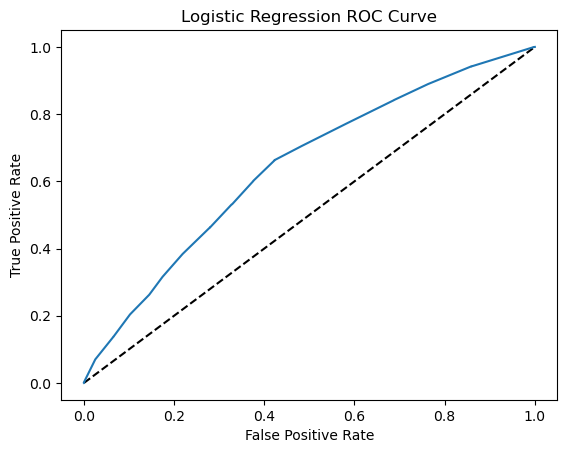

In [24]:
ontime_prob = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, ontime_prob, pos_label = True)
plt.plot([0, 1], [0, 1],
'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

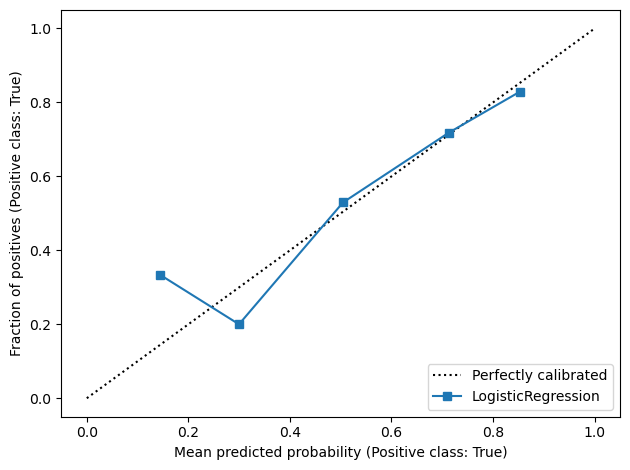

In [25]:
CalibrationDisplay.from_estimator(logreg, X_test, y_test)
plt.tight_layout()

4. Finally, the data you have been provided has an STARTING_ADHERENCE column, which contains the ADHERENCE at the beginning of the route. If you add this metric, does it improve the model?

In [26]:
wego['ROUTE_ABBR'].unique()

array([22, 23,  3,  7, 50, 52, 55, 56], dtype=int64)

In [27]:
predictors = ['ROUTE_ABBR', 'ROUTE_DIRECTION_NAME', 'OPERATOR', 'STARTING_ADHERENCE']
X = wego[predictors]
y = wego['ON-TIME']

## Setting a threshold with Operator counts
operators = wego['OPERATOR'].value_counts()[lambda x:x > 50].index.tolist()
X.loc[X['OPERATOR'].isin(operators), 'OPERATOR'] = -999999

X = pd.get_dummies(X, columns= ['ROUTE_ABBR', 'ROUTE_DIRECTION_NAME', 'OPERATOR'], drop_first = True)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 321, stratify = y)
logreg = LogisticRegression(max_iter=1000).fit(X_train, y_train)

In [28]:
X_test.assign(ontime_prob = logreg.predict_proba(X_test)[:,1],
             prediction = logreg.predict(X_test),
             true = y_test)

,STARTING_ADHERENCE,ROUTE_ABBR_7,ROUTE_ABBR_22,ROUTE_ABBR_23,ROUTE_ABBR_50,ROUTE_ABBR_52,ROUTE_ABBR_55,ROUTE_ABBR_56,ROUTE_DIRECTION_NAME_TO DOWNTOWN,OPERATOR_235,...,OPERATOR_3127,OPERATOR_3134,OPERATOR_3149,OPERATOR_3156,OPERATOR_3165,OPERATOR_3166,OPERATOR_3173,ontime_prob,prediction,true
21408,-3.450000,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0.814549,True,False
17844,-1.033333,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0.828929,True,True
22576,0.883333,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0.796743,True,False
15162,-2.250000,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0.781551,True,True
35894,-5.650000,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.646526,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18453,-38.666666,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0.001207,False,False
35787,-0.383333,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0.914933,True,True
37245,-1.700000,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0.807056,True,True
28637,-3.716666,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.736970,True,True


In [29]:
print('Accuracy score:\n', accuracy_score(y_test, logreg.predict(X_test)))
print('\n')
print('Confusion matrix:\n', confusion_matrix(y_test, logreg.predict(X_test)))
print('\n')
print('Classification Report: \n', classification_report(y_test, logreg.predict(X_test)))
print('\n')
print('ROC auc score: \n', roc_auc_score(y_test, ontime_prob))

Accuracy score:
 0.7794081074359612


Confusion matrix:
 [[ 1079  3298]
 [  250 11457]]


Classification Report: 
               precision    recall  f1-score   support

       False       0.81      0.25      0.38      4377
        True       0.78      0.98      0.87     11707

    accuracy                           0.78     16084
   macro avg       0.79      0.61      0.62     16084
weighted avg       0.79      0.78      0.73     16084



ROC auc score: 
 0.6415615171121227


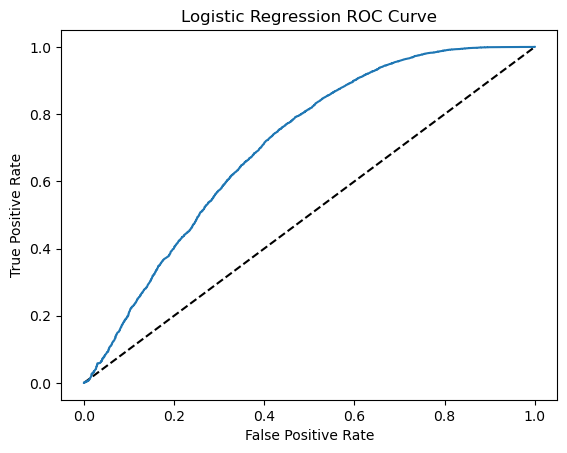

In [30]:
ontime_prob = logreg.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, ontime_prob, pos_label = True)
plt.plot([0, 1], [0, 1],
'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC Curve')
plt.show()

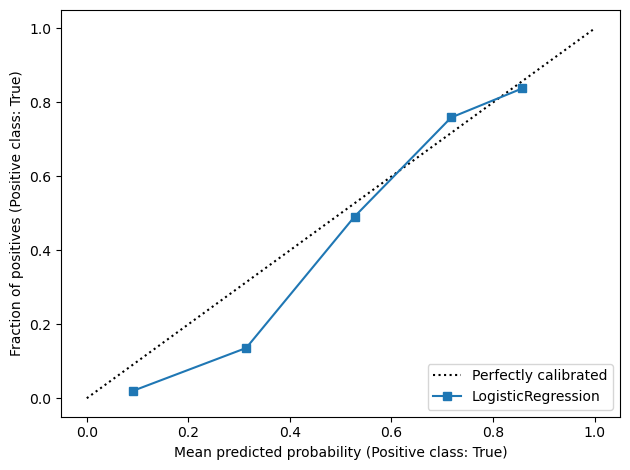

In [31]:
CalibrationDisplay.from_estimator(logreg, X_test, y_test)
plt.tight_layout()
plt.savefig('calibration_curve.png');